In [1]:
import os
import scipy.io as io
from scipy.io import savemat
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from doepy import build
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import platform
import time as tim
import os
import tempfile
from modelisation_physique.Modele_modal_ODE_Xmodes import simulation

%matplotlib widget

In [2]:
#------------------------------------------------Paramètres d'entrée

nb_mode=3;          #Nombre de modes à modéliser
dur=3;              #Durée de l'enregistrement à produire en secondes 
W = 3e-2            #Largeur de la bouche
H = 2e-3            #Longueur de la bouche
gamma_air = 1.4     #Indice adiabatique
rho = 1.292         #Masse vol air
c = 343             #Vitesse son
rc = 3e-2           #rayon de la clarinette
Lc = 60e-2          #longueur clarinette
Sc = np.pi*rc**2    #section clarinette
pM = 0.1            #Pression de plaquage statique

#------------------------------------------Admittances
Y_m=np.ones(nb_mode)*1 /1233.36096998528    #Initialisation de toutes les admittances à une valeur par défaut
Y_m[0] = 1 /1233.36096998528                #Admittance au premier mode
Y_m[1] = 1 /1233.36096998528                #Admittance au deuxième mode
#Y_m[2] = 1 /1233.36096998528

#------------------------------------------Fréquences

f=np.zeros(nb_mode)                 #Initialisation générale fréquences des modes
Leff=Lc                             #Cas Clarinette Zs=0
Leff=Lc+(8*rc/(3*np.pi))            #Cas Clarinette bafflée
#Leff=Lc+0.6*rc                     #Cas Clarinette non bafflée
f=np.array([(2*n+1)*c/(4*Leff) for n in range(nb_mode)]) #Cas particulier de la clarinette (quintoie)

#------------------------------------------------Variables générales

fs = 44100          #Fréquence d'échantillonnage


#------------------------------------------------Variables calculées
omega=np.array([x*2*np.pi for x in f])                  #Conversion freq/puls
F=np.array([2*x* c / Lc for x in range(1,nb_mode+1)])   #Coefficients modaux
time = np.linspace(0,3,fs*3)                            #Vecteur temps


def are_there_oscillations(waveform, epsilon):
    N2_3 = int(len(waveform) / 3)
    criterion = np.mean(np.abs(waveform[N2_3:]))
    return criterion > epsilon


In [11]:
num_samples = 20
parameters = build.space_filling_lhs(
    {"gamma": [0, 1], 
     "zeta": [0, 1]},
    num_samples=num_samples
)

# Create sound samples and associated labels
wave_dataset = np.zeros((num_samples, 132300))
print(wave_dataset.shape)
labels = np.zeros(num_samples)
mean_amplitude = np.zeros(num_samples)

for i, x in tqdm(parameters.iterrows()):
    waveform= simulation(x["gamma"], x["zeta"])
    print(waveform.shape)
    wave_dataset[i] = waveform
    n_1_3 = int(len(waveform)/3)
    mean_amplitude[i] = np.mean(np.abs(waveform[n_1_3:]))
    labels[i] = 1 if are_there_oscillations(waveform, epsilon=0.15) else 0
    
X, y = parameters.to_numpy(), labels

(20, 132300)


0it [00:00, ?it/s]

(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)
(132300,)


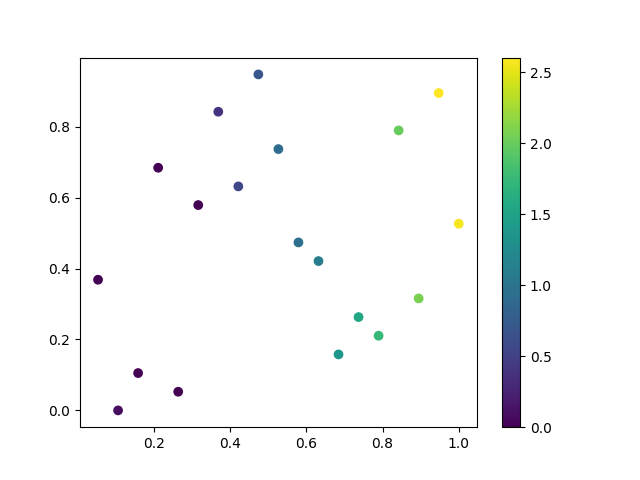

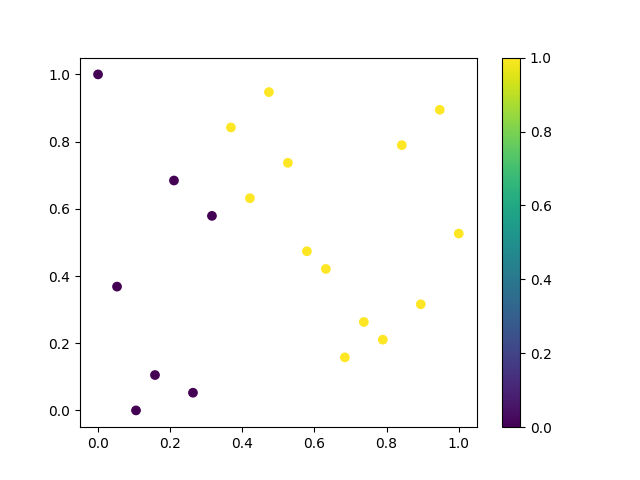

In [12]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=mean_amplitude)
plt.colorbar()
plt.show()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.colorbar()
plt.show()

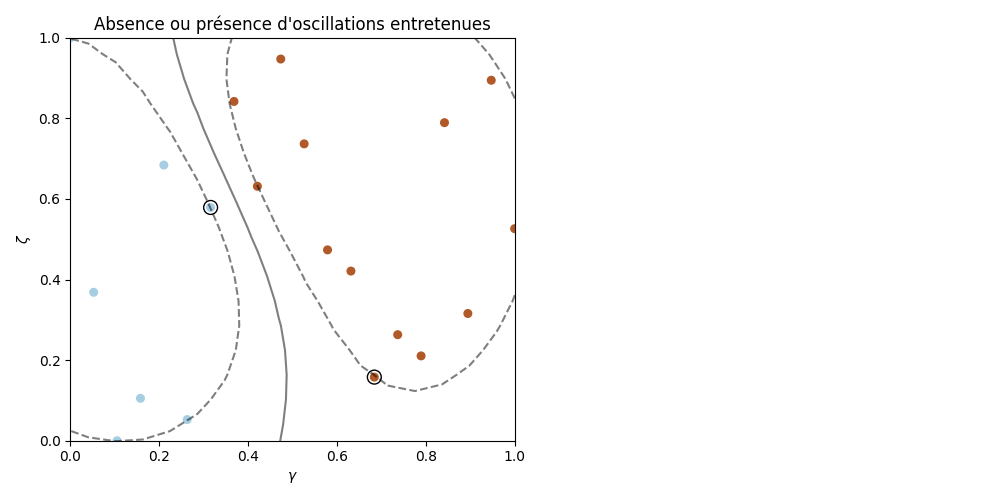

In [13]:
plt.figure(figsize=(10, 5))
for i, C in enumerate([100]):
    # "hinge" is the standard SVM loss
    clf = SVC(C=C, random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("Absence ou présence d'oscillations entretenues")
    plt.xlabel(r"$\gamma$")
    plt.ylabel(r"$\zeta$")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [14]:
io.savemat('X_modale.mat', {"X": X})
io.savemat('labels_modale.mat', {"labels_modale": y})